In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Parametry
days_per_month = {'czerwiec': 30, 'lipiec': 31, 'sierpień': 31, 'wrzesień': 30}
start_dates = {'czerwiec': '2024-06-01', 'lipiec': '2024-07-01', 'sierpień': '2024-08-01'}

# Generujemy temperatury i wilgotności z trendem i fluktuacją
records = []
for month, n_days in days_per_month.items():
    if month == 'wrzesień':
        # wrzesień na razie bez danych (do predykcji)
        for day in range(n_days):
            date = pd.Timestamp(f'2024-09-{day+1:02d}')
            records.append({'date': date, 'month': 'wrzesień', 'temperature': np.nan, 'humidity': np.nan})
        continue
    base_temp = {'czerwiec': 21, 'lipiec': 23, 'sierpień': 22}[month]
    base_hum = {'czerwiec': 65, 'lipiec': 68, 'sierpień': 70}[month]
    for day in range(n_days):
        date = pd.Timestamp(pd.to_datetime(start_dates[month]) + pd.Timedelta(days=day))
        # Symulujemy codzienne fluktuacje, trend i pewną korelację temp-wilgotność
        temp = base_temp + np.sin(2*np.pi*day/30) * 3 + np.random.normal(0, 1)
        hum = base_hum - 0.6*(temp-base_temp) + np.random.normal(0, 2)
        records.append({'date': date, 'month': month, 'temperature': temp, 'humidity': hum})

df = pd.DataFrame(records)
df.head(10)

,date,month,temperature,humidity
0,2024-06-01,czerwiec,21.496714,64.425443
1,2024-06-02,czerwiec,22.271424,67.283206
2,2024-06-03,czerwiec,21.986057,63.940092
3,2024-06-04,czerwiec,24.342569,64.529328
4,2024-06-05,czerwiec,22.759960,65.029144
5,2024-06-06,czerwiec,23.134659,62.787745
6,2024-06-07,czerwiec,24.095132,59.316360
7,2024-06-08,czerwiec,22.258648,63.120236
8,2024-06-09,czerwiec,22.970735,64.446054
9,2024-06-10,czerwiec,22.945145,61.008305


       temperature   humidity
count    92.000000  92.000000
mean     21.901364  67.875903
std       2.342210   3.389802
min      16.537912  59.316360
25%      20.263144  65.611481
50%      21.993994  68.212337
75%      23.523259  69.802154
max      26.707329  76.331258


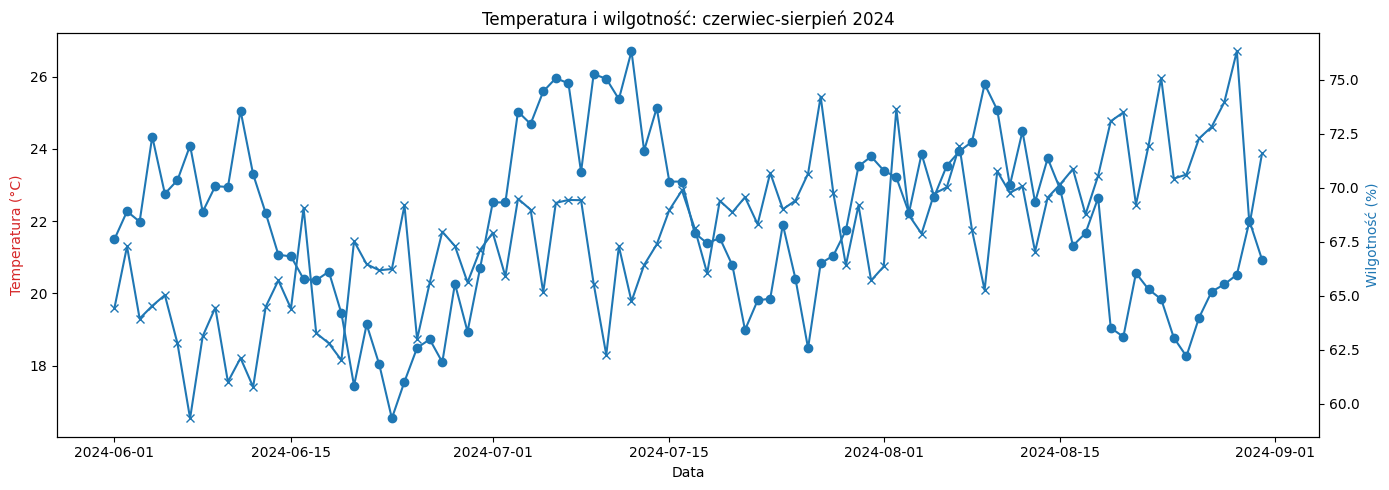

In [2]:
import matplotlib.pyplot as plt

# Wykresy temperatury i wilgotności
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()
ax1.plot(df[df['month'] != 'wrzesień']['date'], df[df['month'] != 'wrzesień']['temperature'], label='Temperatura (°C)', marker='o')
ax2.plot(df[df['month'] != 'wrzesień']['date'], df[df['month'] != 'wrzesień']['humidity'], color='tab:blue', label='Wilgotność (%)', marker='x')

ax1.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.set_ylabel('Wilgotność (%)', color='tab:blue')
ax1.set_xlabel('Data')
ax1.set_title('Temperatura i wilgotność: czerwiec-sierpień 2024')
fig.tight_layout()
plt.show()

# Krótka statystyka
print(df[df['month'] != 'wrzesień'][['temperature', 'humidity']].describe())

In [3]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Przygotowanie danych
df_not_sept = df[df['month'] != 'wrzesień'].copy()
df_not_sept['dayofyear'] = df_not_sept['date'].dt.dayofyear

X = df_not_sept[['dayofyear']].values
y = df_not_sept[['temperature', 'humidity']].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)  # temp i hum
])
model.compile(optimizer='adam', loss='mse')

# Trening
history = model.fit(X_scaled, y_scaled, epochs=200, verbose=0)

# Predykcja na wrzesień
sept = df[df['month'] == 'wrzesień'].copy()
sept['dayofyear'] = sept['date'].dt.dayofyear
X_sept_scaled = scaler_X.transform(sept[['dayofyear']])
y_pred_scaled = model.predict(X_sept_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
sept['temperature'] = y_pred[:,0]
sept['humidity'] = y_pred[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2025-08-06 12:44:38.718569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/python/envs/default_3_11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/python/envs/default_3_11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


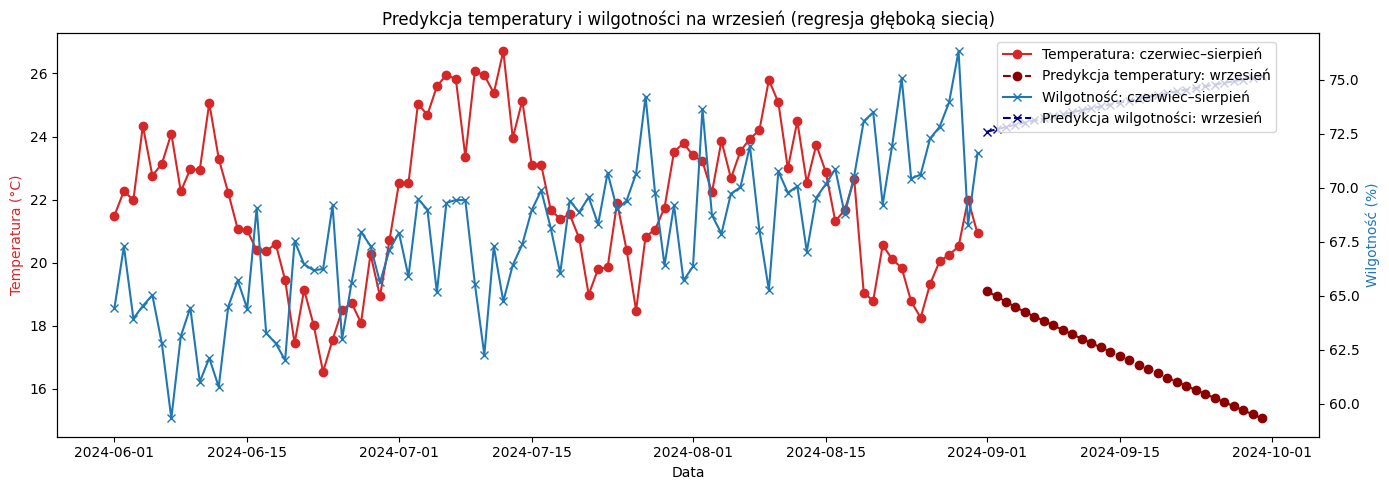

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.plot(df[df['month'] != 'wrzesień']['date'], df[df['month'] != 'wrzesień']['temperature'], label='Temperatura: czerwiec–sierpień', marker='o', color='tab:red')
ax2.plot(df[df['month'] != 'wrzesień']['date'], df[df['month'] != 'wrzesień']['humidity'], label='Wilgotność: czerwiec–sierpień', marker='x', color='tab:blue')

ax1.plot(sept['date'], sept['temperature'], label='Predykcja temperatury: wrzesień', marker='o', linestyle='--', color='darkred')
ax2.plot(sept['date'], sept['humidity'], label='Predykcja wilgotności: wrzesień', marker='x', linestyle='--', color='navy')

ax1.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.set_ylabel('Wilgotność (%)', color='tab:blue')
ax1.set_xlabel('Data')
ax1.set_title('Predykcja temperatury i wilgotności na wrzesień (regresja głęboką siecią)')
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(0.92, 0.92))
plt.show()